In [1]:
import time
from tqdm import tqdm
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate

import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

In [2]:
import torch
cuda_id = 2
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cpu - cpu


In [3]:
paths=[]
labels=[]

for dirname, _, filenames in os.walk('Emotions/input/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('.')[0][::-1]
        name = dirname[::].split('/')[2]
        name_complete = name+'.'+label
        labels.append(name_complete.lower())

In [4]:
data = pd.DataFrame({'speech':paths,'label':labels})
data.sample(10)

,speech,label
11780,Emotions/input/Sad\OAF_bean_sad.wav,sad.wav
518,Emotions/input/Angry\1011_IOM_ANG_XX.wav,angry.wav
2721,Emotions/input/Disgusted\1027_IEO_DIS_HI.wav,disgusted.wav
2670,Emotions/input/Disgusted\1023_ITS_DIS_XX.wav,disgusted.wav
3058,Emotions/input/Disgusted\1051_IEO_DIS_LO.wav,disgusted.wav
1689,Emotions/input/Angry\f13.wav,angry.wav
6793,Emotions/input/Happy\1025_IWL_HAP_XX.wav,happy.wav
5584,Emotions/input/Fearful\1085_ITH_FEA_XX.wav,fearful.wav
10142,Emotions/input/Sad\03-01-04-02-01-01-08.wav,sad.wav
136,Emotions/input/Angry\03-01-05-02-01-02-17.wav,angry.wav


In [5]:
data = data[data.label.apply(lambda x: x != '.ds_store')]

In [6]:
# Labelencoder para convertir las clases a etiquetas númericas
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'label'.
data['label'] = data['label'].apply(lambda x: str(x).split('.wav')[0])
data['label']= label_encoder.fit_transform(data['label'])

In [7]:
data

,speech,label
0,Emotions/input/Angry\03-01-05-01-01-01-01.wav,0
1,Emotions/input/Angry\03-01-05-01-01-01-02.wav,0
2,Emotions/input/Angry\03-01-05-01-01-01-03.wav,0
3,Emotions/input/Angry\03-01-05-01-01-01-04.wav,0
4,Emotions/input/Angry\03-01-05-01-01-01-05.wav,0
...,...,...
12793,Emotions/input/Suprised\YAF_witch_ps.wav,6
12794,Emotions/input/Suprised\YAF_yearn_ps.wav,6
12795,Emotions/input/Suprised\YAF_yes_ps.wav,6
12796,Emotions/input/Suprised\YAF_young_ps.wav,6


In [8]:
nMax = 200 #change to 2500

data2 = data.groupby('label').apply(lambda x: x.sample(n=min(nMax, len(x))))

print(data2['label'].value_counts())

0    200
1    200
2    200
3    200
4    200
5    200
6    200
Name: label, dtype: int64


In [9]:
data2 = data2[data2.label.apply(lambda x: x in (0,1,2,3)) ]

In [10]:
data2.label.value_counts()

0    200
1    200
2    200
3    200
Name: label, dtype: int64

In [11]:
data2.rename(columns={'speech':'path'}, inplace=True)

In [12]:
data2.columns

Index(['path', 'label'], dtype='object')

In [13]:
train_df = data2.sample(frac=0.8)
test_df = data2.drop(train_df.index)

In [14]:
test_df2=test_df.rename(columns = {'label':'labels'})

In [15]:
train_df["label"].value_counts()

0    171
1    164
3    162
2    143
Name: label, dtype: int64

In [16]:
# Display the first data.
import IPython.display as ipd
id = 0
print(train_df.iloc[id])
ipd.Audio(data=train_df.iloc[id]["path"], autoplay=True, rate=16000)

path     Emotions/input/Disgusted\03-01-07-01-01-01-11.wav
label                                                    1
Name: (1, 2177), dtype: object


In [17]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Parameter 'function'=<function map_to_array at 0x0000024D6EB91700> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/640 [00:00<?, ?ex/s]

  0%|          | 0/160 [00:00<?, ?ex/s]

In [18]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {0:0, 1:1, 2:2, 3:3}
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    

train_dataset = EmotionDataset(train_encodings, list(train_data["label"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["label"]))

In [19]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading the model
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)


In [20]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions


In [21]:
# Training

from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 8

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/8


100%|██████████| 320/320 [53:36<00:00, 10.05s/it, Loss=1.159, Accuracy=0.302]


Epoch 2/8


100%|██████████| 320/320 [53:26<00:00, 10.02s/it, Loss=0.440, Accuracy=0.381]


Epoch 3/8


100%|██████████| 320/320 [54:41<00:00, 10.25s/it, Loss=1.035, Accuracy=0.436]


Epoch 4/8


100%|██████████| 320/320 [54:44<00:00, 10.26s/it, Loss=0.930, Accuracy=0.552]


Epoch 5/8


100%|██████████| 320/320 [55:05<00:00, 10.33s/it, Loss=1.064, Accuracy=0.591]


Epoch 6/8


100%|██████████| 320/320 [56:06<00:00, 10.52s/it, Loss=0.124, Accuracy=0.605]


Epoch 7/8


100%|██████████| 320/320 [54:00<00:00, 10.13s/it, Loss=0.361, Accuracy=0.639]


Epoch 8/8


100%|██████████| 320/320 [55:02<00:00, 10.32s/it, Loss=0.377, Accuracy=0.650]


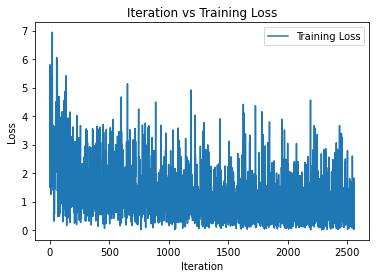

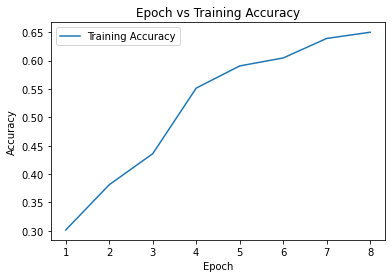

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()


In [23]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 160/160 [03:27<00:00,  1.30s/it, loss=1.070, accuracy=0.431]


The final accuracy on the test dataset: 43.125%


In [24]:
test_df2['emotion']= test_df2.path.apply(lambda x : x.split('/')[2])

In [25]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]
    
df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

# Concat test texts and test records
df = pd.concat([test_df2.reset_index(), df_record["Model Prediction"]], axis=1)
df["emotion"] = df.apply(lambda x: x["emotion"][:3], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions 
df[df["emotion"]!=df["Model Prediction"]]


,label,level_1,path,labels,emotion,Model Prediction
0,0,1760,Emotions/input/Angry\OAF_choice_angry.wav,0,Ang,neu
1,0,1766,Emotions/input/Angry\OAF_deep_angry.wav,0,Ang,neu
2,0,1541,Emotions/input/Angry\1084_ITS_ANG_XX.wav,0,Ang,neu
3,0,466,Emotions/input/Angry\1007_ITS_ANG_XX.wav,0,Ang,neu
4,0,2066,Emotions/input/Angry\YAF_mess_angry.wav,0,Ang,neu
...,...,...,...,...,...,...
155,3,7551,Emotions/input/Happy\1079_MTI_HAP_XX.wav,3,Hap,neu
156,3,6627,Emotions/input/Happy\1013_IWW_HAP_XX.wav,3,Hap,sad
157,3,8047,Emotions/input/Happy\YAF_bath_happy.wav,3,Hap,neu
158,3,6756,Emotions/input/Happy\1022_TSI_HAP_XX.wav,3,Hap,hap


In [26]:
df['Model Prediction'].value_counts()

neu    104
ang     21
sad     19
hap     16
Name: Model Prediction, dtype: int64

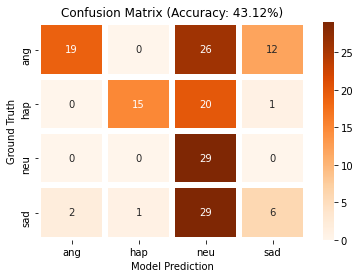

In [27]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

In [30]:
import pickle
pickle.dump(model, open('models/TransferLeaarning_model.model','wb'))